In [1]:
import car_videos

In [2]:
gen = car_videos.threadedProvide()

In [3]:
gen.gi_frame.f_locals

{}

In [4]:
q = next(gen)

In [5]:
import tensorflow as tf
import numpy as np

2021-11-08 17:51:20.805452: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


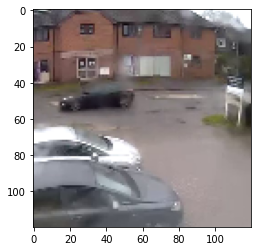

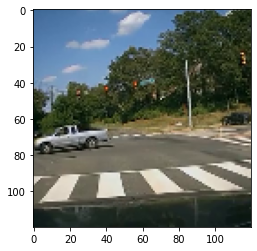

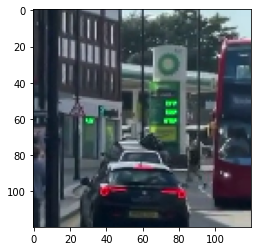

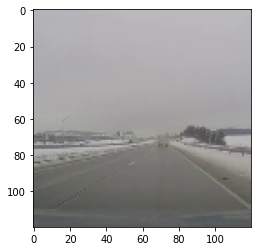

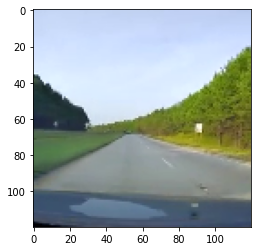

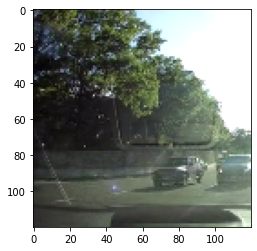

In [6]:
def training_generator():
    while True:
        inp = next(gen).numpy().astype(np.float32) / 255.
        yield (inp[:, :, :, [2, 1, 0]], inp[:, :, :, [6, 5, 4]]), inp[:, :, :, [6, 5, 4]]

import matplotlib.pyplot as plt
for _ in range(6):
    plt.imshow(next(training_generator())[0][0][0])
    plt.show()

In [7]:
import numpy as np

In [8]:
import tensorflow as tf

strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU


In [9]:
BATCH_SIZE = 16 * strategy.num_replicas_in_sync # Gobal batch size.

LEARNING_RATE = 0.001
LEARNING_RATE_EXP_DECAY = 1

SCALE = 1
SIDE_LENGTH = 90





In [10]:
q = training_generator()


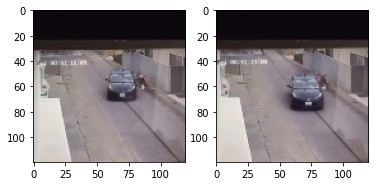

In [11]:
import matplotlib.pyplot as plt
a = next(q)
plt.subplot(1, 2, 1)
plt.imshow(a[0][0][60])
plt.subplot(1, 2, 2)
plt.imshow(a[0][1][60])

In [12]:
FEATURE_LENGTH = 128
import models
    
with strategy.scope():
    model = models.make_model(.6, 90) #, model=models.patchwise_dense_model(90, 128))
# print model layers
model.summary()

# set up learning rate decay
lr_decay = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: LEARNING_RATE * LEARNING_RATE_EXP_DECAY**epoch,
    verbose=True)



2021-11-08 17:51:35.370254: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-11-08 17:51:35.373001: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-11-08 17:51:35.447273: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:17:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2021-11-08 17:51:35.447819: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:b3:00.0 name: GeForce GTX 1050 computeCapability: 6.1
coreClock: 1.455GHz coreCount: 5 deviceMemorySize: 1.94GiB deviceMemoryBandwidth: 104.43GiB/s
2021-11-08 17:51:35.447856: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-11-08 17:5

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 120, 120, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 120, 120, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 90, 90, 128)  5178880     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 8100, 128)    0           sequential[0][0]             

In [15]:
model.load_weights("results/log_probability_2/epoch50/model_weights.tf")

In [16]:
(A, B), Q = a
ofs = 20
A = A[ofs:]
B = B[ofs:]


In [17]:
x = model((A[:10], B[:10]))

2021-11-08 17:52:02.216484: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2021-11-08 17:52:03.319254: W tensorflow/stream_executor/gpu/asm_compiler.cc:98] *** WARNING *** You are using ptxas 9.1.108, which is older than 9.2.88. ptxas 9.x before 9.2.88 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You do not need to update to CUDA 9.2.88; cherry-picking the ptxas binary is sufficient.
2021-11-08 17:52:03.413603: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2021-11-08 17:52:03.413940: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Unimplemented: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perfo

2021-11-08 17:52:06.461238: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2021-11-08 17:52:06.570444: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'



In [18]:
#plt.figure(figsize=(40, 40))
#plt.imshow(x[2, :2000, :2000])

In [19]:
inner_model = model.layers[2]

In [20]:
F_A = tf.reshape(inner_model(A)[:10], (10, SIDE_LENGTH ** 2, FEATURE_LENGTH))
F_B = tf.reshape(inner_model(B)[:10], (10, SIDE_LENGTH ** 2, FEATURE_LENGTH))
cc = tf.linalg.matmul(F_A, F_B, transpose_b=True)
cc_saved = cc
cc = tf.nn.softmax(cc, axis=-1)
cc = tf.reshape(cc, [10] + [SIDE_LENGTH] * 4)
cc = np.array(cc)

2021-11-08 17:52:10.387477: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2021-11-08 17:52:10.499769: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2021-11-08 17:52:10.612683: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2021-11-08 17:52:10.721675: W tensorflow/stream_executor/gpu/

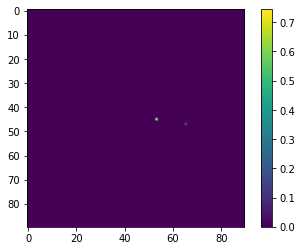

In [21]:
plt.imshow(cc[0, 46, 68])
plt.colorbar()

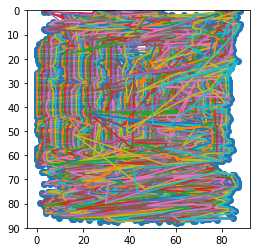

In [22]:
plt.figure(figsize=(4, 4))
import scipy.ndimage
#cc[cc < .05] = 0
grid = np.array(
  [
    [
        [
            scipy.ndimage.measurements.center_of_mass(cc[k, i, j].transpose())
            for i in range(SIDE_LENGTH)
        ]
        for j in range(SIDE_LENGTH)
    ]
   for k in range(10)]
)
#grid[:, :, 0] = scipy.ndimage.gaussian_filter(grid[:, :, 0], 1)
#grid[:, :, 1] = scipy.ndimage.gaussian_filter(grid[:, :, 1], 1)

#grid = grid[3:-3, 3:-3]

plt.plot(grid[0, :, :, 0], grid[0, :, :, 1])
plt.plot(grid[0, :, :, 0].transpose(), grid[0, :, :, 1].transpose())
plt.ylim(SIDE_LENGTH, 0)

plt.scatter(grid[0, :, :, 0], grid[0, :, :, 1])

plt.ylim(SIDE_LENGTH, 0)
plt.show()

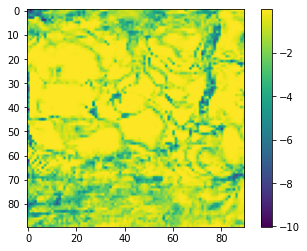

In [23]:
plt.imshow(tf.reshape(x[0], (SIDE_LENGTH, SIDE_LENGTH)))
plt.colorbar()



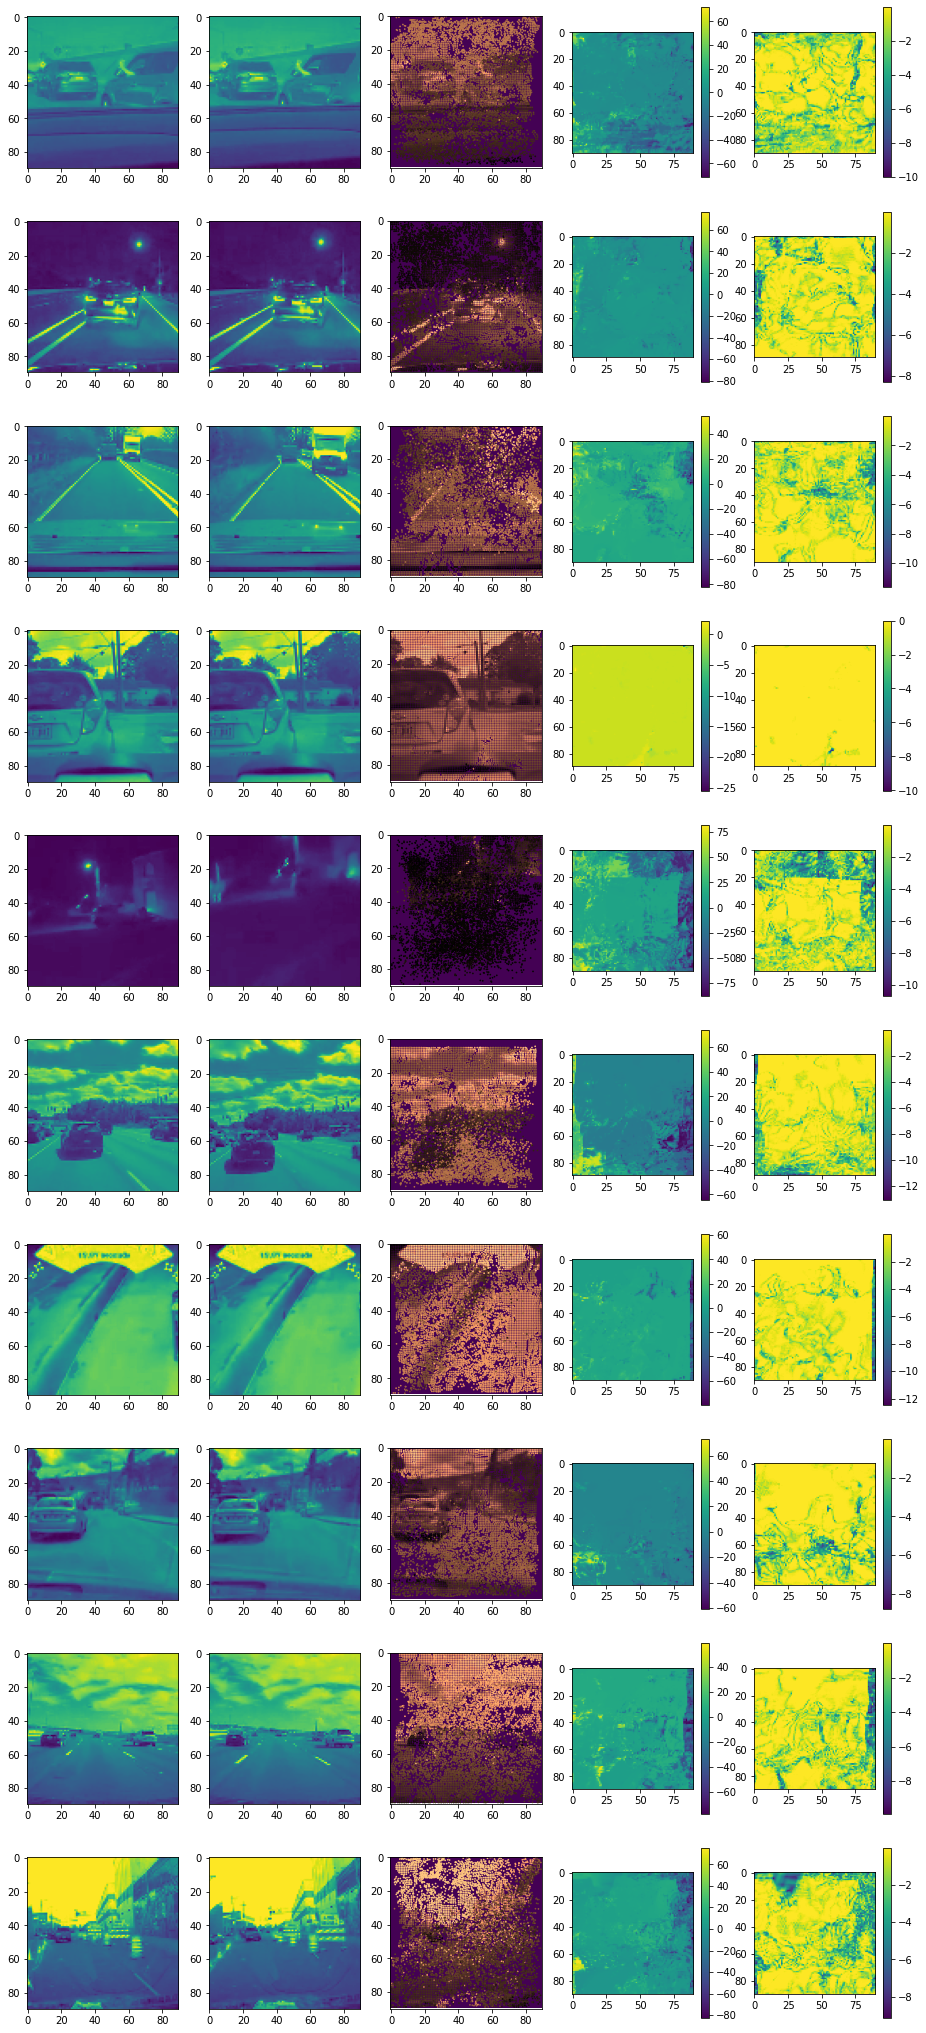

In [24]:
frames_across = 6
plt.figure(figsize=(19, 37))
for k in range(10):
    row_ofs = k * frames_across
    
    plt.subplot(10, frames_across, 1 + row_ofs)
    plt.imshow(A[k, 15:-15, 15:-15, 0])
    plt.subplot(10, frames_across, 2+ row_ofs)
    plt.imshow(B[k, 15:-15, 15:-15, 0])
    plt.subplot(10, frames_across, 3+ row_ofs)
    plt.ylim(SIDE_LENGTH, 0)
    plt.imshow(B[k, 15:-15, 15:-15, 0] * 0)
    plt.scatter(grid[k, :, :, 0], grid[k, :, :, 1], c=np.array(A)[k, 15:-15, 15:-15, 0].transpose(), cmap="copper", s=.5)
    plt.subplot(10, frames_across, 4+ row_ofs)
    g = grid[k].transpose(1, 0, 2)
    plt.imshow(g[:, :, 0] - np.expand_dims(np.arange(90), 0))
    plt.colorbar()
    plt.subplot(10, frames_across, 5+ row_ofs)
    plt.imshow(tf.reshape(x[k], (SIDE_LENGTH, SIDE_LENGTH)))
    plt.colorbar()
    #plt.subplot(10, frames_across, 6+ row_ofs)
    #plt.imshow(cc_val[k])
    #plt.colorbar()

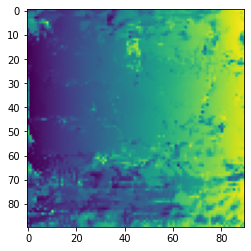

In [25]:
g = grid[0].transpose(1, 0, 2)
plt.imshow(g[:, :, 0])

In [40]:
f_a = np.array(F_A)#.reshape(90, 90, 128)
f_b = np.array(F_B)#.reshape(90, 90, 128)

In [41]:
f_a = f_a.reshape(-1, 128)
f_b = f_b.reshape(-1, 128)

In [42]:

from sklearn import decomposition
pca = decomposition.PCA(n_components=30)

x_a = pca.fit_transform(f_a)
x_b = pca.fit_transform(f_b)

In [43]:
x.shape

TensorShape([10, 8100])

In [44]:
x_a = x_a.reshape(10, 90, 90, 30)
x_b = x_b.reshape(10, 90, 90, 30)

In [45]:
#dd = 0
dd += 1
dd %= 10
plt.imshow(A[dd])
plt.show()
plt.imshow(B[dd])
plt.show()
plt.imshow(x_a.reshape(10, 90, 90, 30)[dd, :, :, 6:9] / 16)
plt.show()
plt.imshow(x_b.reshape(10, 90, 90, 30)[dd, :, :, 6:9] / 16)

NameError: name 'dd' is not defined

In [ ]:
#dd = 0
dd += 1
dd %= 10
plt.imshow(A[dd])
plt.show()
plt.imshow(B[dd])
plt.show()
plt.imshow(np.sum(f_a.reshape(10, 90, 90, 128), axis=-1)[dd])
plt.show()
plt.imshow(np.sum(f_b.reshape(10, 90, 90, 128), axis=-1)[dd])

In [ ]:
plt.plot(pca.components_[0])

In [ ]:
plt.plot(pca.components_[0])

In [ ]:
w = model.get_weights()

In [ ]:
plt.figure(figsize=(5, 43))
for i in range(3):
    for j in range(20):
        plt.subplot(20, 3, 3 * j + i + 1)
        plt.imshow(w[0][:, :, i, j])

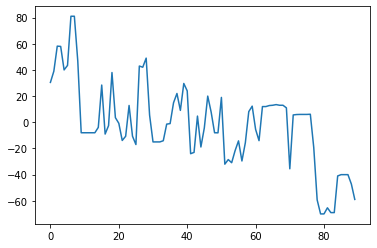

In [44]:
plt.plot(grid[7, 46, :, 1] - range(90))

In [126]:
cc_saved.shape

TensorShape([10, 8100, 8100])

In [24]:
cc_validate = tf.math.reduce_max(cc_saved, axis=-1)

In [25]:
cc_val = tf.reshape(cc_validate, (10, 90, 90))

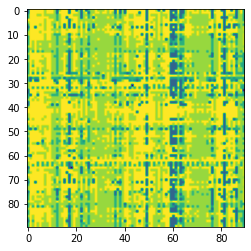

In [26]:
plt.imshow(cc_val[0])

In [156]:
model.layers[2].summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 90, 90, 512)       1476096   
_________________________________________________________________
batch_normalization_8 (Batch (None, 90, 90, 512)       1536      
_________________________________________________________________
activation_8 (Activation)    (None, 90, 90, 512)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 90, 90, 2048)      1048576   
_________________________________________________________________
batch_normalization_9 (Batch (None, 90, 90, 2048)      6144      
_________________________________________________________________
activation_9 (Activation)    (None, 90, 90, 2048)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 90, 90, 512)      

In [65]:
plt.clf()

<Figure size 432x288 with 0 Axes>

In [80]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

#=========================================
# Create Fake Images using Numpy 
# You don't need this in your code as you have your own imageList.
# This is used as an example.


fig = plt.figure(figsize=(10, 10))
ims = []
for i in range(90):
    im = plt.imshow(cc[1, i, i], animated=True, vmin=-20, vmax=100, cmap="jet")
    ims.append([im])
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
plt.close()

# Show the animation
HTML(ani.to_jshtml())

#=========================================
# Save animation as video (if required)
# ani.save('dynamic_images.mp4')


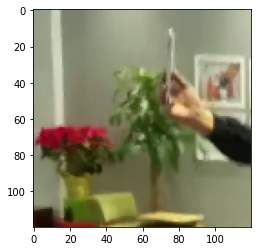

In [154]:
plt.imshow(A[0])

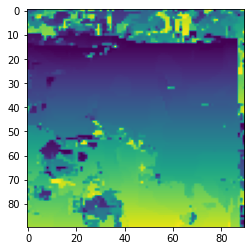

In [153]:
plt.imshow(grid[0, :, :, 0])

<tf.Tensor: shape=(10, 8100, 128), dtype=float32, numpy=
array([[[ 1.16249311e+00,  7.83383787e-01, -8.26226950e-01, ...,
         -1.69134393e-01, -1.62094223e+00, -9.00576711e-01],
        [ 1.16220737e+00,  7.83453465e-01, -8.26107681e-01, ...,
         -1.68939188e-01, -1.62092125e+00, -9.00380611e-01],
        [ 1.16220737e+00,  7.83453465e-01, -8.26107681e-01, ...,
         -1.68939188e-01, -1.62092125e+00, -9.00380611e-01],
        ...,
        [ 1.16227877e+00,  7.83459008e-01, -8.26073349e-01, ...,
         -1.68870375e-01, -1.62099135e+00, -9.00376678e-01],
        [ 1.16227877e+00,  7.83459008e-01, -8.26073349e-01, ...,
         -1.68870375e-01, -1.62099135e+00, -9.00376678e-01],
        [ 1.16228867e+00,  7.83359885e-01, -8.26160848e-01, ...,
         -1.68923691e-01, -1.62092495e+00, -9.00316238e-01]],

       [[ 7.71134973e-01,  7.31475949e-01, -7.39846349e-01, ...,
         -6.01616502e-02, -1.01976943e+00, -6.25713170e-01],
        [ 7.44407654e-01,  8.63871753e-01, -7.

In [48]:
x.shape

TensorShape([10, 8100])

In [49]:
F_A.shape

TensorShape([10, 8100, 128])

In [50]:
F_B.shape

TensorShape([10, 8100, 128])

In [62]:
tf.reduce_mean(tf.clip_by_value(tf.reduce_sum(tf.math.softmax(cc_saved, axis = -1) * tf.math.softmax(cc_saved, axis=-2), axis=-1), -0, .6))

<tf.Tensor: shape=(), dtype=float32, numpy=0.2804975>

In [56]:
x

<tf.Tensor: shape=(10, 8100), dtype=float32, numpy=
array([[1.2318215e-04, 1.2354138e-04, 1.2354138e-04, ..., 1.2346062e-04,
        1.2346062e-04, 1.2334794e-04],
       [3.2543510e-03, 7.5726635e-03, 1.0862375e-02, ..., 1.7122310e-02,
        2.6281770e-02, 2.5971312e-06],
       [7.1840580e-03, 1.3570132e-02, 4.7549102e-03, ..., 7.5759371e-03,
        6.6649109e-02, 1.6707626e-01],
       ...,
       [5.3977233e-01, 6.0000002e-01, 6.0000002e-01, ..., 4.0541989e-01,
        3.0521479e-01, 1.5414172e-02],
       [2.9069888e-03, 1.1870767e-03, 3.0917462e-03, ..., 8.0412843e-07,
        3.5709011e-08, 1.6584574e-06],
       [6.0000002e-01, 6.0000002e-01, 6.0000002e-01, ..., 1.8088665e-10,
        1.7845203e-09, 1.7708854e-07]], dtype=float32)>

In [60]:
tf.reduce_mean(x)

<tf.Tensor: shape=(), dtype=float32, numpy=0.2804975>

In [66]:
np.save("test_data/F_A.npy", F_A.numpy())
np.save("test_data/F_B.npy", F_B.numpy())

In [117]:
g = grid[4].transpose(1, 0, 2)
g.shape
vv = g.copy()
vv[:, :, 0] -= np.arange(90)
vv[:, :, 1] -= np.arange(90)[:, None]


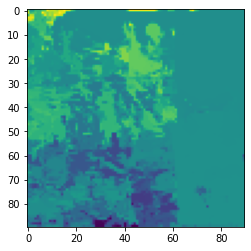

In [118]:
plt.imshow(vv[:, :, 1])

In [119]:
vv = vv.reshape(90 * 90, 2)

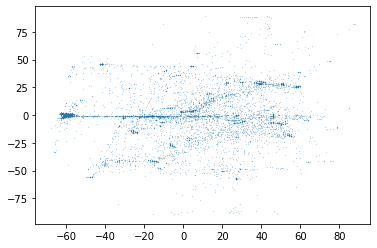

In [120]:
plt.scatter(vv[:, 0], vv[:, 1], s=.01)

In [67]:
ims = a[0][0]
ims_normed = ims / np.sqrt(.0001 + np.sum(ims**2, axis=-1, keepdims=True))

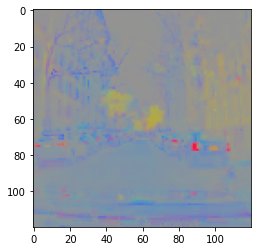

In [71]:
plt.imshow(ims_normed[10])
plt.show()

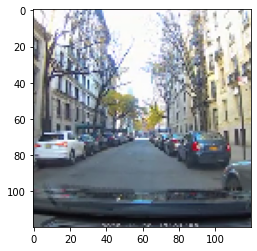

In [72]:
plt.imshow(ims[10])

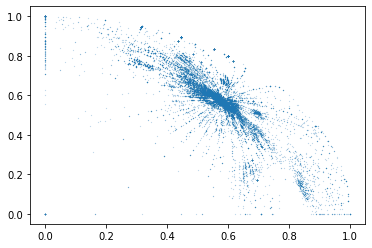

In [58]:
plt.scatter(ims_normed[:, 100:150, 100:150, 0], ims_normed[:, 100:150, 100:150, 2], s=.01)

In [73]:
import footsteps

Input name of experiment:
saved_batch


In [77]:
np.save(footsteps.output_dir + "saved_batch.pth", a)

/playpen1/tgreer/anaconda3/envs/FMAPICON/lib/python3.9/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [81]:
import pickle
with open(footsteps.output_dir + "saved_car_batch.pickle", "wb") as f:
    pickle.dump(a, f)